## Run the preprocessing pipeline

In [1]:
from preprocessing_pipeline import run_pipeline
from app.utils.rag_constants import *

input_file = f'gs://{BUCKET}/merged_datasets2.csv'
output_file = f'gs://{BUCKET}/clean_merge.json'

run_pipeline(input_file, output_file)

ModuleNotFoundError: No module named 'utils'

## Load the Knowledge Graph into neo4J

The following code loads the knowledge graph into neo4J.

Make sure neo4J desktop is currently open and the Neo4J database engine is currently running.

To connect to a different database, change NEO4J_URI, NEO4J_USERNAME, and NEO4J_PASSWORD in utils/rag_constants.py

In [1]:
from app.utils import print_debug
from app.utils import neo4j_client

ontology = "sample_data/e_commerce_website_pooja.owl"
csv_file = "sample_data/giftcard.csv" # MERGED_DATA = "merged_datasets2.csv"

kg_loader = neo4j_client.KnowledgeGraphLoader(ontology, csv_file)
kg_loader.load_knowledge_graph(reset=True) # this deletes the existing graph in neo4J and replaces it with the KG.

Ontology loaded from sample_data/e_commerce_website_pooja.owl: [a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']].
Connected to Neo4J instance at bolt://localhost:7687


KeyboardInterrupt: 

### Build Additional Details with LLM and Cypher queries

In [ ]:
from app.llm_handler import get_model, prompt_llm

In [ ]:
PROMPT_CYPHER_WRITE= """
"Extract key points of the given item from its description (such as color, material(s), brand name, manufacturer, product line, or others) and edit the Cypher query below to add the key points to the graph. Return only the edited Cypher query.

User query:
{user_query}

Cypher query:
MATCH (n)
WHERE n.title = {item}
add new connection or create a new node with the property.
"""

In [ ]:
csv_file = "sample_data/giftcard.csv" 

## Girvan-Newman clustering algorithm

The following code runs Girvan-Newman on the neo4J graph.

On a large graph, this can take a very long time.

In [2]:
from girvan_newman import GirvanNewman

gn = GirvanNewman()

Connected to Neo4J instance at neo4j+s://508011ec.databases.neo4j.io
Running Girvan-Newman algorithm... This may take a while.
Finished running Girvan-Newman.


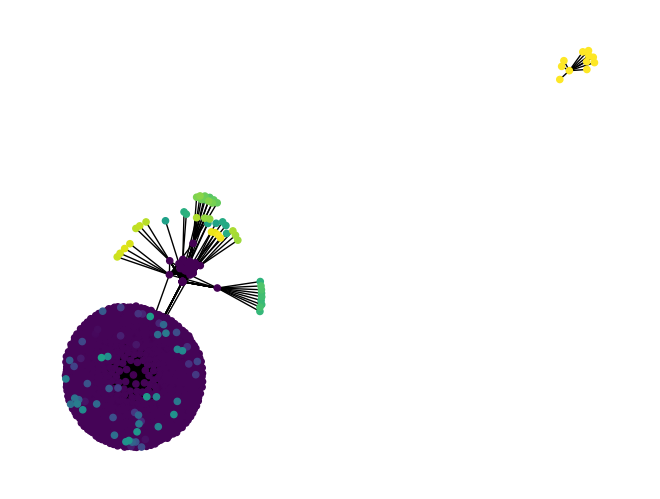

In [3]:
gn.draw_colored_graph(iteration=100)

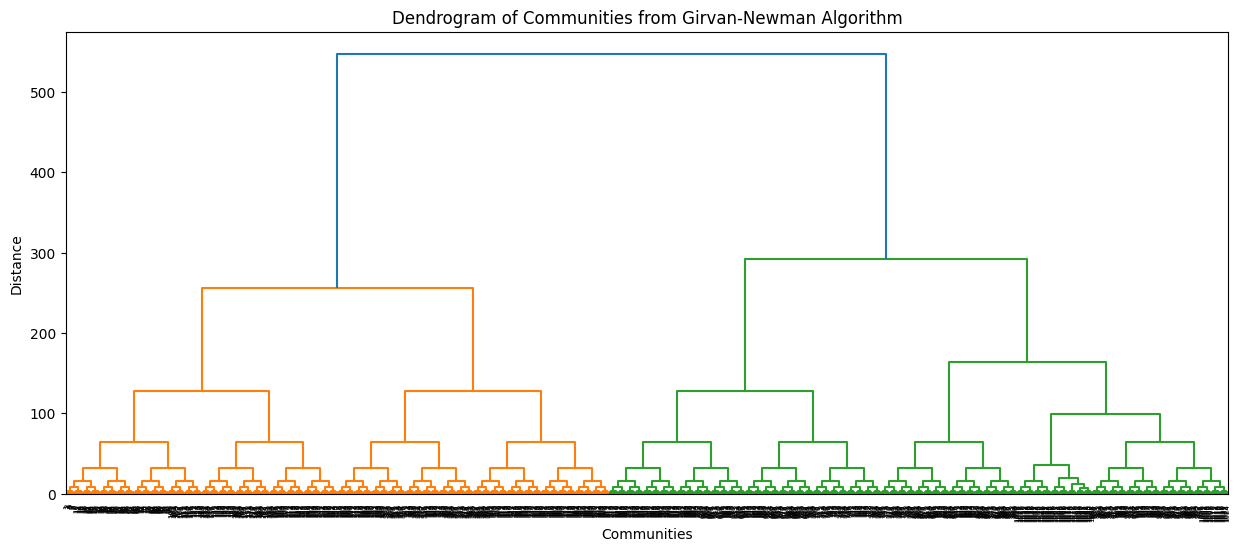

In [4]:
gn.draw_gn_dendrogram()

## Retrieve Nodes

In [1]:
from app.utils import neo4j_client

Q_FUZZY_MATCH = """
MATCH (n)
WHERE n.title STARTS WITH 'Pet'
RETURN n
"""
# or CONTAINS (performance hit)

driver = neo4j_client.get_driver()
r = neo4j_client.exec_query(driver,Q_FUZZY_MATCH)
print(r)

Connected to Neo4J instance at neo4j+s://508011ec.databases.neo4j.io
Query `
MATCH (n)
WHERE n.title STARTS WITH 'Pet'
RETURN n
` returned 4 records in 57 ms.
<Record n=<Node element_id='4:1761f531-f98e-4bec-b8ee-7ff7130ea5fb:84' labels=frozenset({'PetSmart Gift Card'}) properties={'features': "Gift cards are valid online and in store for merchandise, training, grooming, PetSmart PetsHotel and Doggie Day Camp.', 'Redemption: Instore and Online', 'No returns and no refunds on gift cards.'", 'images': "{'thumb': 'https://m.media-amazon.com/images/I/41CP7hgynoL. SX38 SY50 CR,0,0,38,50 .jpg', 'large': 'https://m.media-amazon.com/images/I/41CP7hgynoL.jpg', 'variant': 'MAIN', 'hi res': None}", 'price': 25.0, 'averageRating': 4.8, 'mainCategory': 'Gift Cards', 'description': "Gift cards make the perfect gift - letting the recipient choose exactly what they wish to purchase. Gift cards are valid online and in store for merchandise, training, grooming, PetSmart, PetsHotel and Doggie Day Camp.'"

In [2]:
print(r[0])

<Record n=<Node element_id='4:1761f531-f98e-4bec-b8ee-7ff7130ea5fb:84' labels=frozenset({'PetSmart Gift Card'}) properties={'features': "Gift cards are valid online and in store for merchandise, training, grooming, PetSmart PetsHotel and Doggie Day Camp.', 'Redemption: Instore and Online', 'No returns and no refunds on gift cards.'", 'images': "{'thumb': 'https://m.media-amazon.com/images/I/41CP7hgynoL. SX38 SY50 CR,0,0,38,50 .jpg', 'large': 'https://m.media-amazon.com/images/I/41CP7hgynoL.jpg', 'variant': 'MAIN', 'hi res': None}", 'price': 25.0, 'averageRating': 4.8, 'mainCategory': 'Gift Cards', 'description': "Gift cards make the perfect gift - letting the recipient choose exactly what they wish to purchase. Gift cards are valid online and in store for merchandise, training, grooming, PetSmart, PetsHotel and Doggie Day Camp.'", 'ratingNumber': 1990, 'store': 'Petsmart', 'categories': "Gift Cards', 'Gift Card Categories', 'Specialty Cards'", 'title': 'PetSmart Gift Card', 'parent asi

In [3]:
r[0].get('exists')

In [ ]:
r = neo4j_client.exec_query(driver,Q_FUZZY_MATCH)
print(r)

## RAG

In [1]:
from app.llm_handler import LLMHandler, AvailableLLMs

prompt = "I am looking for a gift card suitable as a birthday gift for a writer."
llm_handler = LLMHandler(AvailableLLMs.FLANT5)
llm_handler.get_llm_response(prompt)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
c:\Users\lawfu\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


c:\Users\lawfu\AppData\Local\Programs\Python\Python39\lib\site-packages\tf_keras\src\initializers\initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Connected to Neo4J instance at bolt://localhost:7687
Cypher query: MATCH (n:Product)
WHERE n.mainCategory IN ['Gift Cards']
RETURN n LIMIT 10

Query `MATCH (n:Product)
WHERE n.mainCategory IN ['Gift Cards']
RETURN n LIMIT 10
` returned 10 records in 3 ms.
<Record n=<Node element_id='4:18655faf-f289-46b6-a710-f954a897ebb5:602' labels=frozenset({'Amazon.com Gift Card in Gift Tag (Various Designs)', 'Product'}) properties={'features': "Gift Card is affixed inside a gift tag', 'Gift amount may not be printed on Gift Cards', 'Gift Card has no fees and no expiration date', 'No returns and no refunds on Gift Cards', 'Gift Card is redeemable towards millions of items storewide at Amazon.com', 'Scan and redeem any Gift Card with a mobile or tablet device via the Amazon App', 'Free One-Day Shipping (where available)', 'Customized gift message, if chosen at check-out, only appears on packing slip and not on the actual gift card or carrier'", 'images': "{'thumb': 'https://m.media-amazon.com/images

('',
 [<Record n=<Node element_id='4:18655faf-f289-46b6-a710-f954a897ebb5:602' labels=frozenset({'Amazon.com Gift Card in Gift Tag (Various Designs)', 'Product'}) properties={'features': "Gift Card is affixed inside a gift tag', 'Gift amount may not be printed on Gift Cards', 'Gift Card has no fees and no expiration date', 'No returns and no refunds on Gift Cards', 'Gift Card is redeemable towards millions of items storewide at Amazon.com', 'Scan and redeem any Gift Card with a mobile or tablet device via the Amazon App', 'Free One-Day Shipping (where available)', 'Customized gift message, if chosen at check-out, only appears on packing slip and not on the actual gift card or carrier'", 'images': "{'thumb': 'https://m.media-amazon.com/images/I/41ZA96xtATL. SX38 SY50 CR,0,0,38,50 .jpg', 'large': 'https://m.media-amazon.com/images/I/41ZA96xtATL.jpg', 'variant': 'MAIN', 'hi res': 'https://m.media-amazon.com/images/I/71cWJvVGYtL. SL1500 .jpg'}, {'thumb': 'https://m.media-amazon.com/images/

In [1]:
from app.llm_handler import LLMHandler, AvailableLLMs

prompt = "I am looking for a gift card suitable as a birthday gift for a writer."
llm_handler = LLMHandler(AvailableLLMs.GEMINI)
llm_recommendation, retrieved_nodes = llm_handler.get_llm_response(prompt)

print(len(retrieved_nodes))


Connected to Neo4J instance at bolt://localhost:7687
Query `MATCH (n:Product)
WHERE n.mainCategory IN ['Gift Cards']
RETURN n` returned 993 records in 0 ms.
<Record n=<Node element_id='4:18655faf-f289-46b6-a710-f954a897ebb5:602' labels=frozenset({'Product', 'Amazon.com Gift Card in Gift Tag (Various Designs)'}) properties={'features': "Gift Card is affixed inside a gift tag', 'Gift amount may not be printed on Gift Cards', 'Gift Card has no fees and no expiration date', 'No returns and no refunds on Gift Cards', 'Gift Card is redeemable towards millions of items storewide at Amazon.com', 'Scan and redeem any Gift Card with a mobile or tablet device via the Amazon App', 'Free One-Day Shipping (where available)', 'Customized gift message, if chosen at check-out, only appears on packing slip and not on the actual gift card or carrier'", 'images': "{'thumb': 'https://m.media-amazon.com/images/I/41ZA96xtATL. SX38 SY50 CR,0,0,38,50 .jpg', 'large': 'https://m.media-amazon.com/images/I/41ZA96

## Evaluate

In [7]:
from app.llm_handler import LLMHandler, AvailableLLMs

prompt = "Please generate 10 prompts and ground truths for calculating BLEU and ROUGE score calculations for a recommender system on Gift Card data."
llm_handler = LLMHandler(AvailableLLMs.GEMINI)
llm_handler.get_llm_response(prompt)

# Example evaluation

#prompt = "Gift card for writer?"
#reference = "The best gift cards are available in various categories like beauty and office products."
#generated = "Gift cards for beauty and office products are among the best available."

Connected to Neo4J instance at bolt://localhost:7687
Query `MATCH (n:Product)
WHERE n.mainCategory IN ['Gift Cards']
RETURN n.name, n.description LIMIT 10` returned 10 records in 10 ms.
<Record n.name=None n.description='"Amazon.com Gift Cards are the perfect way to give them exactly what they\'re hoping for - even if you don\'t know what it is. Amazon.com Gift Cards are redeemable for millions of items across Amazon.com. Item delivered is a single physical Amazon.com Gift Card nested inside or with a free gift accessory."'>
<Record n.name=None n.description="Mastercard Gift Cards are the ideal gift – to give and receive. When you give a Mastercard Gift Card, your gift is the perfect choice for any occasion including holidays, birthdays, graduations, anniversaries, or any other celebration. Shop online and make purchases anywhere Debit Mastercards are accepted in the U.S. Purchase a Mastercard Gift Card and your gift will be perfect every time.'">
<Record n.name=None n.description='"Tr

('', '')

In [24]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge


prompts = [
    "I am looking for a gift card suitable as a birthday gift for a writer."
    ,"I have to book a restaurant for a family gathering. Please recommend me a product."
    ,"I need to get a gift card for my manger's farewell party."
    ,"I want to get something for my mother for Mother's Day. She likes red."
    ,"Recommend three gift cards suitable for a 25-year-old female who enjoys outdoor activities and fitness."
    ,"Suggest five gift cards appropriate for a corporate holiday gift, aiming for a broad appeal."
    ,"Recommend one gift card for a wedding gift, considering the couple enjoys cooking and entertaining."
    ,"Find gift cards suitable for a teenager interested in video games and technology."
    ,"Suggest two gift cards for someone who appreciates fine dining and experiences."
    ,"Recommend a gift card for a child who loves art supplies."
]
ground_truths = [
    "The best gift cards are available in various categories like beauty and office products."
    ,"I recommend family restaurants with options for large gatherings, the ability to book ahead, and a variety of food options."
    ,"A general purpose gift card for Amazon, Starbucks, Visa, or popular retailers like Walmart and Target."
    ,"Gift cards in red colors, for general stores like Amazon or Target whose logo features red, or things your mother likes."
    ,"Amazon Gift Card (versatile), REI Gift Card (outdoor gear), a gift card to a local yoga studio (fitness)."
    ,"General purpose cards like Amazon Gift Card, Starbucks Gift Card, Visa Gift Card, Mastercard Gift Card, or a gift card to a popular online retailer like Target or Walmart."
    ,"Williams Sonoma Gift Card or a similar high-end kitchen supply store gift card."
    ,"Steam Gift Card, Playstation Network Gift Card, or an Amazon Gift Card (for online game purchases)."
    ,"Gift card to a high-end restaurant (local or national chain), a gift card to a wine shop or a gourmet food store."
    ,"Michaels Gift Card, Amazon Gift Card (for art supplies), or a local art store gift card."
]

# Function to calculate BLEU and ROUGE scores
def evaluate_response(generated_response, reference_response):
    bleu_score = sentence_bleu([reference_response.split()], generated_response.split())
    rouge = Rouge()
    rouge_score = rouge.get_scores(generated_response, reference_response)[0]
    return {"BLEU": bleu_score
            , "ROUGE_r": rouge_score['rouge-1']['r']
            , "ROUGE_p": rouge_score['rouge-1']['p']
            , "ROUGE_f": rouge_score['rouge-1']['f']
            , "ROUGE2_r": rouge_score['rouge-2']['r']
            , "ROUGE2_p": rouge_score['rouge-2']['p']
            , "ROUGE2_f": rouge_score['rouge-2']['f']
        }

In [ ]:
from app.llm_handler import LLMHandler, AvailableLLMs

generated = []
for prompt in prompts:
    # if unimpelemnted in the new LLMHandler
    # get_llm_respponse(prompt)
    
    # using the new LLMHandler
    llm_handler = LLMHandler(AvailableLLMs.GEMINI)
    llm_recommendation = llm_handler.prompt_llm(prompt)
    generated.append(llm_recommendation)


In [2]:
print(generated)

["The best gift card for a writer depends on their specific needs and preferences. Here are a few ideas, categorized for easier decision-making:\n\n**For the practical writer:**\n\n* **Amazon:** This is a versatile option, allowing them to buy books, writing supplies (pens, notebooks, etc.), software, and more.\n* **Target or Walmart:** Similar to Amazon, these offer a broad range of items, including office supplies, books, and potentially tech accessories.\n* **Barnes & Noble:**  Perfect for book-loving writers who might need research materials or want to treat themselves to a new release.\n\n**For the digitally focused writer:**\n\n* **Scrivener:** This is a popular writing software used by many authors.  A gift card for this would be a significant investment in their writing process.\n* **ProWritingAid:** This is a grammar and style checker that helps writers improve their work.\n* **Grammarly Premium:** Similar to ProWritingAid, offering grammar and style checking, and more.\n\n\n*

In [27]:
import pandas as pd

metrics = []

for i in range(0, len(prompts)):
    evaluation_result = evaluate_response(generated[i], ground_truths[i])
    metrics.append(evaluation_result)

df = pd.DataFrame(metrics)
df.head()



c:\Users\lawfu\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\lawfu\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\lawfu\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower o

,BLEU,ROUGE_r,ROUGE_p,ROUGE_f,ROUGE2_r,ROUGE2_p,ROUGE2_f
0,3.353124e-79,0.500000,0.039548,0.073298,0.153846,0.007353,0.014035
1,1.886858e-155,0.631579,0.085106,0.150000,0.052632,0.004762,0.008734
2,6.208222e-79,0.437500,0.072165,0.123894,0.133333,0.015748,0.028169
3,2.236176e-155,0.250000,0.060976,0.098039,0.050000,0.010000,0.016667
4,1.561932e-02,0.466667,0.056452,0.100719,0.250000,0.022222,0.040816


In [31]:
df.mean()

BLEU        0.005901
ROUGE_r     0.445292
ROUGE_p     0.062834
ROUGE_f     0.106729
ROUGE2_r    0.139036
ROUGE2_p    0.016359
ROUGE2_f    0.028268
dtype: float64